## Initialize

> **Note**: This calculation does not support `jax`. *[jan25]*

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
import numpy as np
import os
from classy_sz import Class as Class_sz

**Cosmological parameters**

In [2]:
cosmo_params= {
    'omega_b': 0.02,
    'omega_cdm':  0.12,
    'H0': 80., 
    'tau_reio': 0.0561,
    'ln10^{10}A_s': 3.047,
    'n_s': 0.9665, 
    "cosmo_model": 0, # 1: use mnu-lcdm emulators; 0: use lcdm with fixed neutrino mass, currently vrms2 does not support emulators

}

**Precision parameters**

In [3]:
precision_params = {
## check k_min_for_pk_in_vrms2,... if needed
}

## Compute

In [4]:
%%time

zmin = 0.
zmax = 5.

classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set(precision_params)
classy_sz.set({
'output': 'vrms2',
'skip_class_sz': 0,
'z_min' : zmin,
'z_max' : zmax,
})
# classy_sz.compute_class_szfast() ## does not support emulators
classy_sz.compute()

CPU times: user 5.63 s, sys: 14.6 ms, total: 5.64 s
Wall time: 1.33 s


In [5]:
nzs = 500
zs = np.linspace(zmin,zmax,nzs)
vrms2 = classy_sz.get_vrms2_at_z(zs)

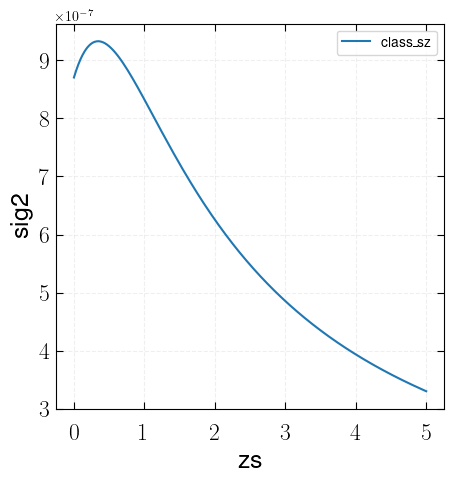

In [7]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_xlabel(r"zs",size=title_size)
ax.set_ylabel(r"sig2",size=title_size) ## 1/3*vrms2 in units of c2

ax.plot(zs,vrms2,label='class_sz') ## 
ax.legend()